# INSTRUCTIONS

#### Part 1: Computing the optimal speed from the optimal racing line
- Part 1 of this notebook takes the optimal racing line, which can be generated with Race-Line-Calculation.ipynb ([GitHub](https://github.com/cdthompson/deepracer-k1999-race-lines)), and generates the optimal speed for each point on the racing line
- Input: .py file with 2D array containing optimal racing line: 2 columns (x,y)
- Output: .py file with 2D array: 4 columns (x,y,speed,expected time). This array can be inserted into the reward function
- Note: The last point of the racing line is deleted because it is the same point as the first one

#### Part 2: Computing the Action Space
- Part 2 of this notebook takes the optimal racing line and speed, and uses K-Means with Gaussian Noise infused data, to calculate the action space

#### Acknowledgement 

This notebook was forked from https://github.com/dgnzlz/Capstone_AWS_DeepRacer
For more details, please refer to the original repo.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Path of the optimal racing line (.npy file)
fpath = "reinvent_base-1000-4-2024-03-16-223413.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "2024 DeepRacer Championship Cup"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]

# Helper functions for Part 1 and Part 2

In [3]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print('Constant multiple for optimal speed:{}'.format(constant_multiple))
 

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

# Part 1: Calculate optimal speed

- Change ```LOOK_AHEAD_POINTS``` to influence how many points the algorithm looks ahead (the higher, the sooner the car will start to break)
- Change ```MIN_SPEED``` and ```MAX_SPEED``` to fit the track and model !

In [30]:
LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.3
MAX_SPEED = 3.2

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed:1.6286748338601726


#### Visualization

Constant multiple for optimal speed:1.6286748338601726


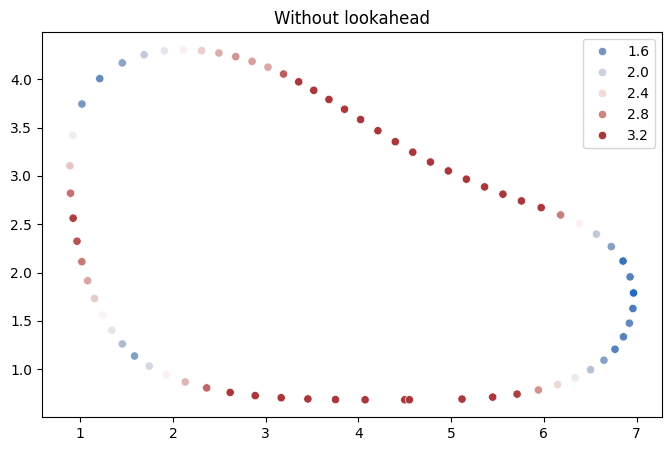

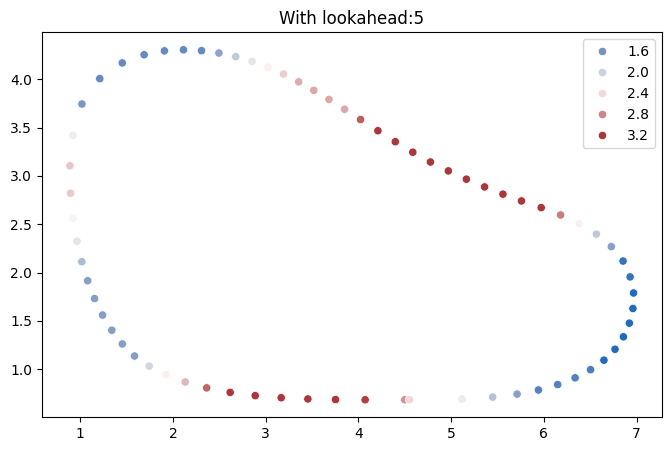

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    "With lookahead:{}".format(LOOK_AHEAD_POINTS))

#### Calculate distance and optimal time between each racing point

In [32]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print("Total time for track, if racing line and speeds are followed perfectly: {} s".format(total_time))

Total time for track, if racing line and speeds are followed perfectly: 7.620607327390951 s


## Append everything together and save to .txt file

In [33]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [34]:
# Write to txt file
with open('optimals_newest_{}.txt'.format(TRACK_NAME), 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

# Part 2: Calculate Optimal Action Space

In [9]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)
    
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

<Axes: >

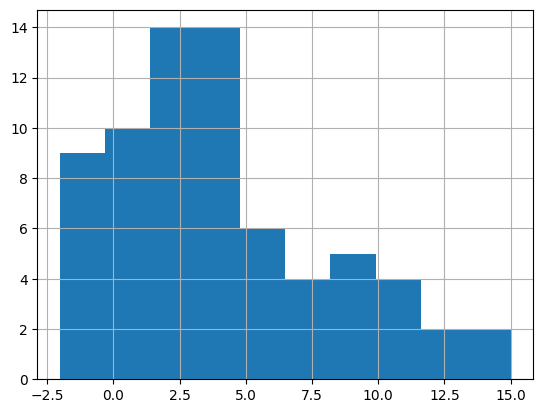

In [10]:
all_actions.steering.hist()

In [11]:
all_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   velocity  70 non-null     float64
 1   steering  70 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB


In [12]:
min(radius)

0.6371151511729232

<Axes: >

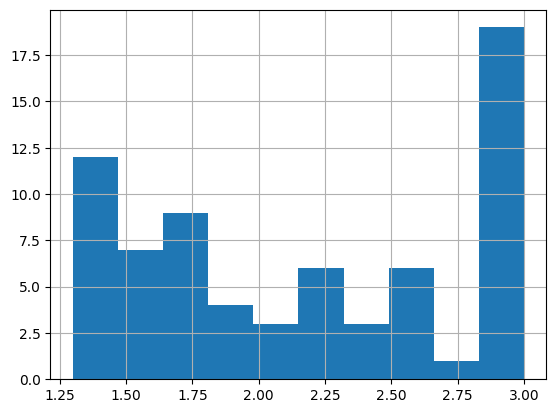

In [13]:
all_actions.velocity.hist()

Text(0.5, 1.0, 'With lookahead: 5')

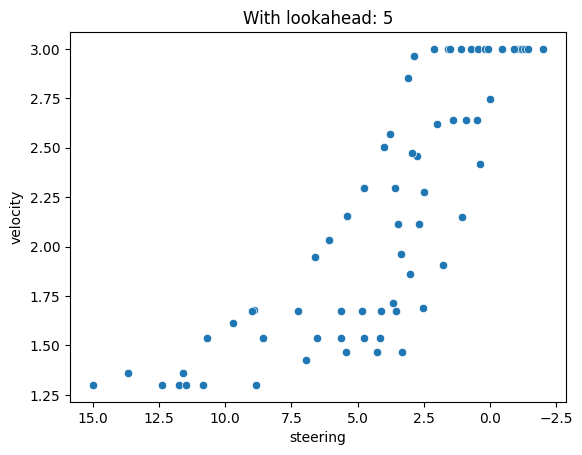

In [14]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title("With lookahead: {}".format(LOOK_AHEAD_POINTS))

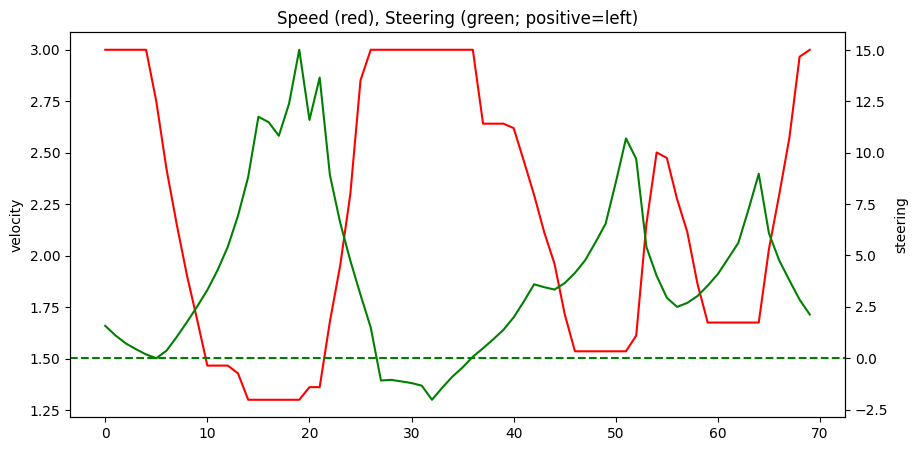

In [15]:
# Visualize all actions
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green; positive=left)")

#### Calculate Action Space with K-Means and Resampling each point with normal distribution

<Axes: ylabel='Density'>

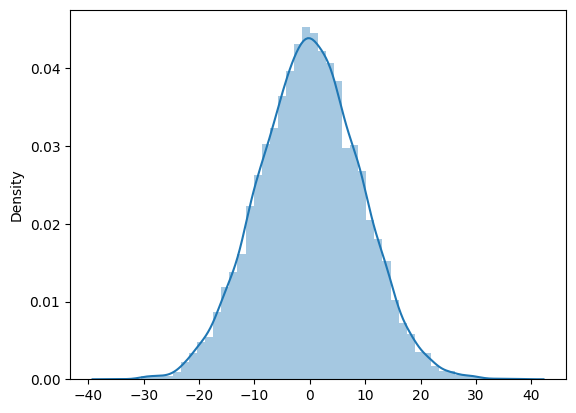

In [16]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0,steering_sd,10000))

In [17]:
steering_sd

9.119352478676534

<Axes: ylabel='Density'>

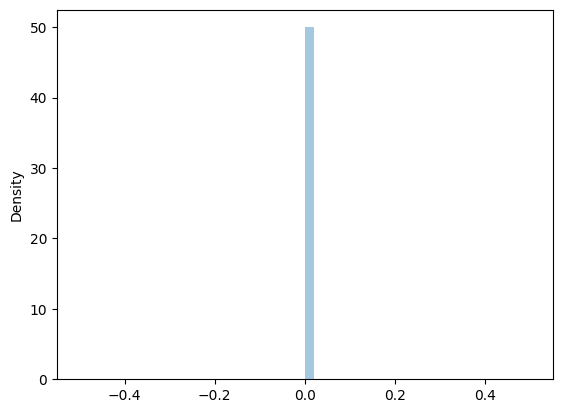

In [18]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0,velocity_sd,10000))

In [19]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(61803, 2)

In [20]:
all_actions_norm

,velocity,steering
0,2.748860,-8.239427e-13
1,2.420152,3.682047e-01
2,2.151970,1.037841e+00
3,1.904478,1.759794e+00
4,1.688851,2.515251e+00
...,...,...
61798,2.032581,6.081286e+00
61799,2.294837,4.767305e+00
61800,2.571988,3.793628e+00
61801,2.966194,2.851382e+00


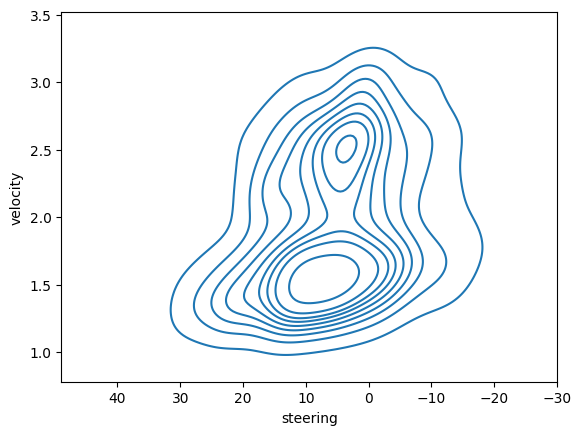

In [27]:
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True)
ax = sns.kdeplot(x=all_actions_norm_less["steering"], y=all_actions_norm_less["velocity"])
ax.invert_xaxis()

In [21]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), 
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 21-2
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_), 
                                   columns=["steering","velocity"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED],"steering":[30,-30]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

In [22]:
action_space_e

,steering,velocity
0,1.512856,13.223064
1,2.376721,-5.423786
2,2.597414,1.551835
3,1.452269,-5.540982
4,1.930221,5.092526
5,1.315179,10.304771
6,2.957979,1.663099
7,2.575317,11.562150
8,2.044368,-6.771019
9,1.677245,3.673921


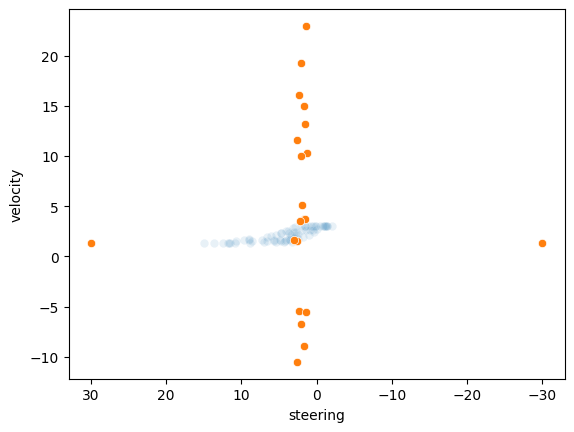

In [23]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

*Note: Action space can be different every time it is computed because of randome resampling with gaussian noise and also because of the random seed with K-Means. Therefore, try out multiple iterations until you are happy with the result*

#### Output as JSON format

In [24]:
# Output JSON format
action_space_for_json = action_space_e[["steering","velocity"]].copy()
    
action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False)

action_space_for_json

,steering_angle,speed,index
0,1.5129,13.2231,0
1,2.3767,-5.4238,1
2,2.5974,1.5518,2
3,1.4523,-5.5410,3
4,1.9302,5.0925,4
5,1.3152,10.3048,5
6,2.9580,1.6631,6
7,2.5753,11.5622,7
8,2.0444,-6.7710,8
9,1.6772,3.6739,9


In [25]:
with open('AS21_newest_{}.txt'.format(TRACK_NAME), 'w') as f:
    f.write(json_text)